<a href="https://colab.research.google.com/github/VMBoehm/UndergradStudentProjects/blob/master/Copy_of_(D%3D2%2C_50)_Convergence_Properties_of_PyDelfi_VanessasChanges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np

#### Problem statement:    
Our forward model for the data is d=Ax+b + n, where n is Gaussian noise, A is a prefactor, x is the underlying signal. We are interested in inferring b (possible A). x follows a standard normal distribution, n follows a Gaussian distribution with mean zero and variance sigma^2.

#### Week 1:   
Questions:
- What is the expression for P(x)? 
- What is the expression for P(d|x,A,b) (The probability of the data given a realization of x)?
- How do we compute P(b|d,A)? (Hint: Bayesian theorem and marginalization. how is P(b|d,A) related to  P(x,d|A,b)?, How is P(x,d|b,A) related to P(d|x,A,b)?)
- Can you find the actual expression for P(b|d,b)?
- How does PyDelfi compute P(A|d)?

Coding:  
- write a function that generates realizations of 'x'. (for now x, n and d are just scalars)
- write a function that generates realizations of 'n'.
- write a function that calls these two functions to generate data.
- Generate many (N=1000) realizations of the data and plot the distribution.

#### data generating functions

In [0]:
def generate_signal(dims=2, n_sample=100, random_seed=None):
    
    np.random.seed(random_seed)
    x = np.random.randn(n_sample,dims)
    return x

def generate_noise(sigma, dims=2, n_sample=100, random_seed=None):
    
    np.random.seed(random_seed)
    n = np.random.randn(n_sample,dims)*sigma
    return n

def generate_data(A, b, sigma, dims, n_sample, random_seeds=[None,None]):
    signal= generate_signal(dims, n_sample, random_seed=random_seeds[0])
    noise = generate_noise(sigma, dims, n_sample, random_seed=random_seeds[1])
    data  = A*signal+b+noise
    
    return data

#### problem specifications

In [0]:
# this is the dimensionality of the data
dims      = 2
# this is the noise level in our measurement
sigma     = 0.1
# this is the amplitude parameter
A_true    = 0.5
# this is the mean value parameter (the parameter we are interested in inferring from the data)
b_true    = np.asarray([-3,3])

In [0]:
# now we generate the data, that will be our 'measurement'. 
# The aim is to infer the parameter of interest from this measurement.
data      = generate_data(A_true,b_true,sigma,dims,n_sample=1, random_seeds=[568,176])

For the solution to P(b|d,A), see the notes I'll be sending alongside with this. 
In the specific case we are considering here, P(b|d,A) is Gaussian, but in general this is not the case.
Btw, just because the data is Gaussian distributed, doesnt mean the posterior for the parameters P(params|data) is Gaussian.

From our calculation we find that P(d|b) is Gaussian with mean b and covariance (sigma^2+A^2), let's empirically check if this is true, by plotting the histogram:  


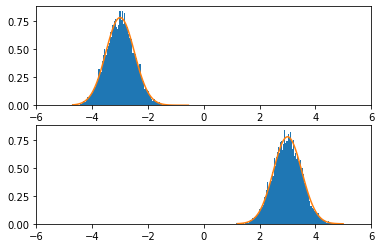

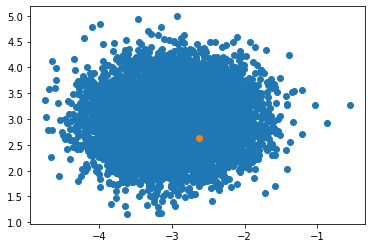

In [0]:
def Gaussian_per_dim(x,Mu,Sigma):
    return 1/np.sqrt(np.pi*2.)/Sigma*np.exp(-0.5*(x-Mu)**2/Sigma**2)

# draw a large data sample to visualize the data distribution
data_sample = generate_data(A_true,b_true,sigma,dims,n_sample=10000)
# and plot it for each dimension
plt.figure()
for ii in range(dims):
    plt.subplot(dims,1,ii+1)
    _, bins,_ = plt.hist(data_sample[:,ii], density=True,bins=100)
    delta = np.diff(bins) 
    bins  = bins[0:-1]+delta
    plt.plot(bins,np.squeeze(Gaussian_per_dim(bins,b_true[ii],(A_true**2+sigma**2)**(0.5))))
    plt.xlim(-6,6)
plt.show()

## -> spot on!

# in 2 d a scatter plot also helps us visualize what the data distribution looks like and if our 'measurement' is a typical data point

plt.scatter(data_sample[:,0],data_sample[:,1])
plt.scatter(data[:,0],data[:,1])

#### How does Pydelfi compute P(b|d)?    
Pydelfi learns P(d|b) from simulations that generate data from given parameter values. It then multiplies it with a given prior to obtain P(d,b) and then evaluates it at a given data point to get P(b|d).

In [0]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

!pip install -q https://github.com/justinalsing/pydelfi/archive/master.zip

TensorFlow 1.x selected.
1.15.2


#### pydelfi on our example

In [0]:
import pydelfi.priors as priors
import pydelfi.ndes as ndes
import pydelfi.delfi as delfi
import tensorflow as tf

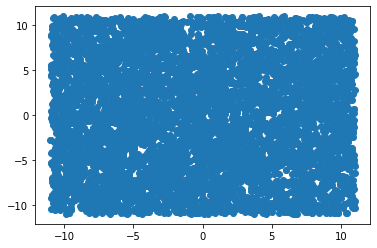

In [0]:
# we first have to create training data, i.e. pairs (data, b), that we can feed into pydelfi for training

# let's just sample values for b on a grid for now
# trying different sampling methods is what the other students are gonna look at, but you are free to also test how they influence the result

lower = -10
upper = 10

#randomly drawing training sampled from uniform distribution to speed up things
num_training_samples = 80**2
upper_sample = upper+1
lower_sample = lower-1
bs = (np.random.rand(num_training_samples, b_true.shape[-1])-0.5)*(upper_sample-lower_sample)+(upper_sample+lower_sample)/2.

#plot to see that they are actually well unirfomly distributed
plt.figure()
plt.scatter(bs[:,0],bs[:,1])
plt.show()

# if that takes too long you can think about parallizing it with 'map' and 'pool'. 
training_data = []
training_params = []
for b in bs:
    training_params.append(b)
    training_data.append(generate_data(A_true,b,sigma,dims,n_sample=1))
training_params = np.squeeze(np.asarray(training_params))
training_data   = np.squeeze(np.asarray(training_data))



In [0]:
# num_training_samples = 50**2
# bs = np.linspace(-7,7,np.int(np.sqrt(num_training_samples)))
# lower = -7
# upper = 7
# training_data = []
# training_params = []
# for b_0 in bs:
#     for b_1 in bs:
#         training_params.append(np.asarray([b_0,b_1]))
#         training_data.append(generate_data(A_true,training_params[-1],sigma,dims,n_sample=1))
# training_params = np.squeeze(np.asarray(training_params))
# training_data   = np.squeeze(np.asarray(training_data))

In [0]:
# next we define our prior 
# do we have any preknowledge about the parameter values?
# for now let's assume we now that they are bigger than -6 and smaller than 6
lower_array = np.repeat(lower,b_true.shape[-1])
upper_array = np.repeat(upper,b_true.shape[-1])
prior = priors.Uniform(lower_array, upper_array)

now we need to design our networks
let's use a gaussian mixture model with one Gaussian (because we know that this should be sufficient)

mixture density network takes the data and feeds it through a neural network. The output of the neural network are the parameters of a Gaussian mixture model (means, covariances, weights) which represents P(d,params). It then evaluates P(d,params) for the current training pair. The network parameters are chosen to maximize this probability.

In [0]:
# we need to specify the number of parameters, the datat dimensionality, the number of components in the Gaussian mixture model, and the number of hidden layers in the network
NDEs = [ndes.MixtureDensityNetwork(n_parameters=len(b_true), n_data=dims, n_components=1, n_hidden=[2,2], activations=[tf.tanh,tf.tanh], index=0)]




The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
# next we define a pydelfi estimator object
# we feed in our measurement, our prior and the parameter limits and names
param_names = ['b'+str(ii) for ii in range(b_true.shape[-1])]

DelfiEnsemble = delfi.Delfi(np.squeeze(data), prior, NDEs, 
                            Finv = None, 
                            theta_fiducial = None, 
                            param_limits = [lower_array,upper_array],
                            param_names = param_names, 
                            input_normalization=None,restore=False)

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().





In [0]:
## then we feed in our training data
DelfiEnsemble.load_simulations(training_data,training_params)

In [0]:
## and train
DelfiEnsemble.train_ndes()

INFO:tensorflow:Restoring parameters from graph_checkpoint


In [0]:
del training_data
del training_params

NameError: ignored

In [0]:
### to analyze the resulting model we draw samples from it
posterior_samples = DelfiEnsemble.emcee_sample()

Removed no burn in


/usr/local/lib/python3.6/dist-packages/pydelfi/delfi.py:626: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


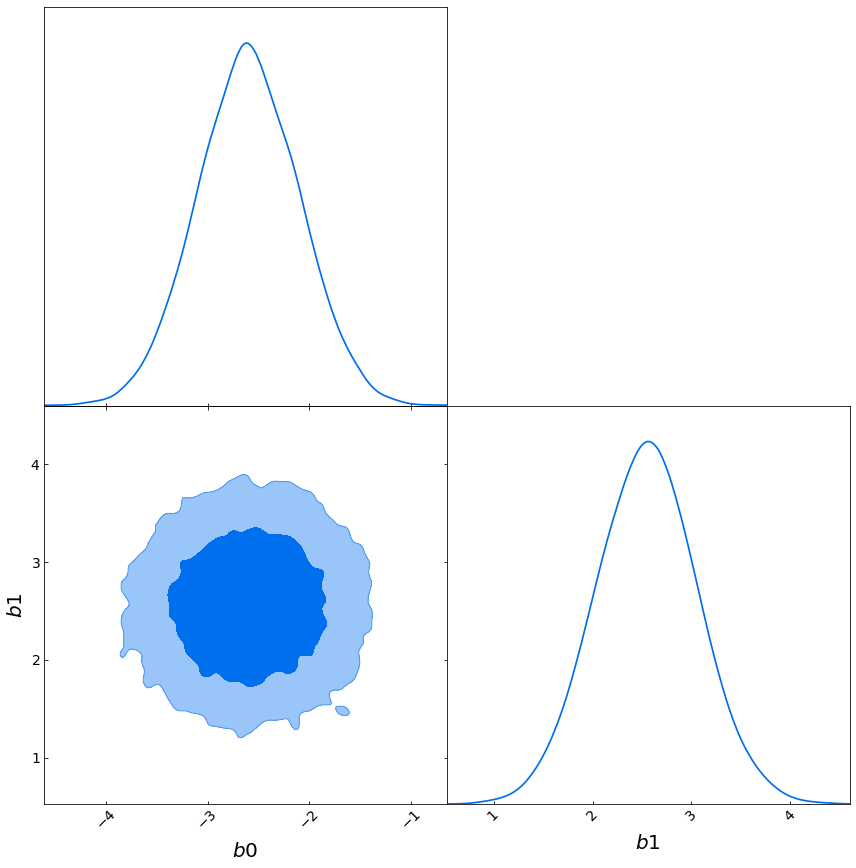

In [0]:
### and plot these samples
DelfiEnsemble.triangle_plot([posterior_samples])

In [0]:
#### this is the posterior that pydelfi fits
### this might not be normalized? 
#log_likelihood = lambda x: DelfiEnsemble.log_posterior_stacked(x, data)[0]
#log_likelihood(b_true)


## this is the likelihood that pydelfi fits (= posterior for flat prior that extends far enough), should be correctly normalized
pydelfi_log_posterior = lambda x: DelfiEnsemble.log_posterior_stacked(x, data)[0]
pydelfi_log_posterior(b_true)

array([8.45357769])

In [0]:
len(posterior_samples)

100000

In [0]:
#draw sample from true posterior
def true_posterior_samples(n_samples, mean, cov):
  L = np.linalg.cholesky(cov)

  samples = np.random.randn(n_samples,mean.shape[-1])
  samples = np.dot(samples,L)+mean

  return samples

true_posterior_samples = true_posterior_samples(10000, data, np.diag(np.ones(data.shape[-1])*(A_true**2+sigma**2)))

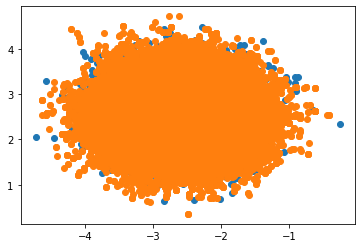

In [0]:
plt.scatter(true_posterior_samples[:,0],true_posterior_samples[:,1])
plt.scatter(posterior_samples[:,0],posterior_samples[:,1])

[-2.60679601  2.58999584]


In [0]:
pydelfi_mean = np.mean(posterior_samples[-10000::],axis=0)
print(pydelfi_mean)
pydelfi_covariance = np.dot((posterior_samples[-10000::]-pydelfi_mean[None,:]).T,(posterior_samples[-10000::]-pydelfi_mean[None,:]))/(10000-1)

In [0]:
def KL_Gaussians(mean0,cov0,mean1, cov1):
  cov1inv=np.linalg.inv(cov1)
  mm = (mean1-mean0)
  return 0.5*(np.trace(np.dot(cov1inv,cov0))+np.dot(mm.T, np.dot(cov1inv,mm))-2+np.log(np.linalg.det(cov1)/np.linalg.det(cov0)))

In [0]:
# this is the KL divergence between the pydelfi posterior and the true posterior (better way to estimate this?)
KL_Gaussians(b_true,np.diag([(A_true**2+sigma**2),(A_true**2+sigma**2)]),pydelfi_mean, pydelfi_covariance)

0.6681496618213307

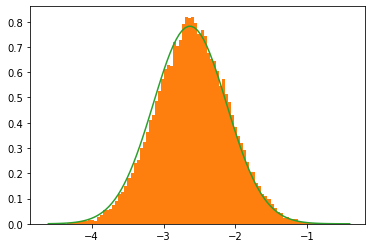

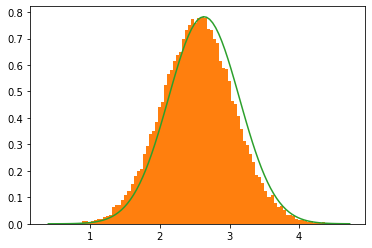

In [0]:
# since we know the correct solution, let's overplot
for ii in range(len(b_true)):
    _, bins, _ =plt.hist(posterior_samples[:,ii], density=True, bins=100)
    _ =plt.hist(posterior_samples[:,ii], density=True, bins=bins)
    delta = np.diff(bins) 
    bins  = bins[0:-1]+delta
    plt.plot(bins,np.squeeze(Gaussian_per_dim(bins,data[:,ii],(A_true**2+sigma**2)**(0.5))))
    plt.show()
## and they agree!

### Now let's estimate the same Gaussian from the data in a conventional fashion (this is what we should actually be comparing against). For this we would also need to run simulations, typically at a fiducial parameter value, which we think is roughly true. Measure the covariance of that data and use it as covariance in our posterior approximation.

shape: (6400, 2)
mean: [ 0.00555942 -0.0041602 ] [-2.60679601  2.58999584]


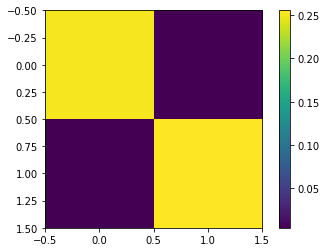

covariances
0.26
[0.25182517 0.25541068]


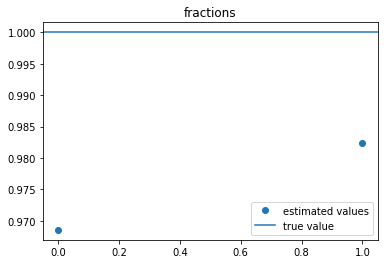

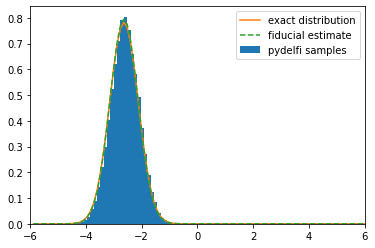

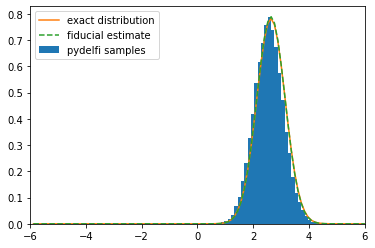

In [0]:
# fiducial parameter values 
b_fid = [0,0]

# generate as many data samples at this value as we used training samples for pydelfi
training_data_fid = generate_data(A_true,b_fid,sigma,dims,n_sample=num_training_samples)

print('shape:', training_data_fid.shape)

#compute mean and covariance of this training data
mean = np.mean(training_data_fid, axis=0)
cov  = np.dot((training_data_fid-mean).T,(training_data_fid-mean))/(len(training_data_fid)-1)

# inspect the results
print('mean:', mean, pydelfi_mean)
plt.figure()
plt.imshow(cov)
plt.colorbar()
plt.show()
# the covariance is diagonal, which is expected, because the different data space dimensions should be uncorrelated. That's how we defined our model.

# in our case we know the true covariance, so we can compare against it. Turns out, the covariance estimation is very good!
print('covariances')
print((A_true**2+sigma**2))
print(np.diag(cov))
plt.figure()
plt.title('fractions')
plt.plot(np.diag(cov)/(A_true**2+sigma**2),ls='',marker='o', label='estimated values')
plt.axhline((A_true**2+sigma**2)/(A_true**2+sigma**2),label='true value')
plt.legend()
plt.show()

#now let's compare our estimated distribution with the truth and the pydelfi samples.
for ii in range(len(b_true)):
    _, bins, _ =plt.hist(posterior_samples[:,ii], density=True, bins=100, range=(-6,6),label='pydelfi samples')
    delta = np.diff(bins) 
    bins  = bins[0:-1]+delta
    plt.plot(bins,np.squeeze(Gaussian_per_dim(bins,data[:,ii],(A_true**2+sigma**2)**(0.5))), label='exact distribution')
    plt.plot(bins,np.squeeze(Gaussian_per_dim(bins,data[:,ii],np.diag(cov)[ii]**(0.5))),label='fiducial estimate', ls='--')
    plt.xlim(-6,6)
    plt.legend()
    plt.show()


# can you fit a Gaussian to the pydelfi samples?

In [0]:
# this is the KL divergence between the 'traditional' posterior and the true posterior (better way to estimate this?)
KL_Gaussians(b_true,np.diag([(A_true**2+sigma**2),(A_true**2+sigma**2)]),np.squeeze(data), cov)

0.5397452691619284

#### For next week: 
- go through and ask yourself if you understand all the steps in the code above. Let me know if there's something you do not understand.
- go through the quadratic completion that I sent. Did you get the same result? :)
- Try to make changes to the above example:
    - what happens if you increase the data dimensionality? (note that for our example dim(b) has to be dim(data), wil will change that in the future)
    - what happens if you decrease the number of training samples?
    - can you identify breaks points? If the number of training samples is less, equal, bigger or much bigger than the data dimensionality?
    - how can we measure the discrepancy between the Gaussian that pydelfi fitted and the true distribution? Can you fit a Gaussian to the pydelfi samples? Have you heard about the KL divergence? Can you compute it for two Gaussians?
- make sure you record/save all of your findings!

#### Next steps:
- Think of an example (and code it up), where dim(b)<dim(d), but our posterior is still Gaussian in b. Run the same tests on this example. What happens as you change dim(b) with respect to dim(d) and the number of training samples?
- Think of and code an example where dim(signal)>dim(data). (Hint you might want to make A a fixed matrix). How does  P(b|d,A) look like if A is a matrix (hint it makes sense to also make sigma a diagonal matrix)?
- Now look at how well pydelfi does as we increase the dimenionality of the signal.

At this point we should schedule a project wide call to report our results!

- Depending on what we find, we can go into several directions:
    - we can move to non-Gaussian distributions (non gaussian in data and non-gaussian in parameters).
    - we can try different data compression schemes (pydelfi uses score compression, this might be subpotimal, if we dont have enough data samples).
